In [2]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import seaborn as sns

In [4]:
train_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_err2.csv')
train_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_qui2.csv')
train_prob = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_prob2.csv')

test_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_err2.csv')
test_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_qui2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
test_err_code_frq = pd.read_csv('/content/drive/Shareddrives/dacon/404/preprocessed/테스트_에러_에러코드별_발생횟수.csv', index_col=['Unnamed: 0'])
train_err_code_frq = pd.read_csv('/content/drive/Shareddrives/dacon/404/preprocessed/트레인_에러_에러코드별_발생횟수.csv', index_col=['Unnamed: 0'])

test_err_type_frq = pd.read_csv('/content/drive/Shareddrives/dacon/404/preprocessed/테스트_에러_에러타입별_발생횟수.csv', index_col=['Unnamed: 0'])
train_err_type_frq = pd.read_csv('/content/drive/Shareddrives/dacon/404/preprocessed/트레인_에러_에러타입별_발생횟수.csv', index_col=['Unnamed: 0'])

test_err_sum_byday = pd.read_csv('/content/drive/Shareddrives/dacon/404/preprocessed/테스트_에러발생_일일누적합계.csv', index_col=['Unnamed: 0'])
train_err_sum_byday = pd.read_csv('/content/drive/Shareddrives/dacon/404/preprocessed/트레인_에러발생_일일누적합계.csv', index_col=['Unnamed: 0'])

test_qui_frq = pd.read_csv('/content/drive/Shareddrives/dacon/404/preprocessed/테스트_퀼리티_항목별_많이등장.csv', index_col=['Unnamed: 0'])
train_qui_frq = pd.read_csv('/content/drive/Shareddrives/dacon/404/preprocessed/트레인_퀼리티_항목별_많이등장.csv', index_col=['Unnamed: 0'])

test_qui_sum_byday = pd.read_csv('/content/drive/Shareddrives/dacon/404/preprocessed/테스트_퀼리티로그_일일수집합계.csv', index_col=['Unnamed: 0'])
train_qui_sum_byday = pd.read_csv('/content/drive/Shareddrives/dacon/404/preprocessed/트레인_퀼리티로그_일일수집합계.csv', index_col=['Unnamed: 0'])

In [52]:
train_qui2 = train_qui.copy()
test_qui2 = test_qui.copy()
train_err2 = train_err.copy()
test_err2 = test_err.copy()

# 퀼리티 3,4는 값이 1밖에 없어서 의미가 없기 때문에 제외
# 펌웨어 버전은 이미 err 자료에 있기 때문에 중복으로 제외
# 퀼리티 0은 EDA 결과 퀼리티 2와 피어슨 상관계수 0.99를 보이기 때문에 0과 2 중에 하나만 골랐음
# 0의 결측치 Nan은 15%고 2의 결측치는 4%기 때문에 결측치가 적은 2를 남기고 0은 drop 시킨다.

## 퀼리티 6과 7도 0.81로 강한 상관관계를 보이고 있는데, 하나를 제외해야 하나 고민이 됨
train_qui2.drop(['fwver','quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)
test_qui2.drop(['fwver', 'quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)

test_qui2 = test_qui2.replace(',','', regex=True)
train_qui2 = train_qui2.replace(',','', regex=True)
test_qui2.loc[:,'quality_0':'quality_12'] = test_qui2.loc[:,'quality_0':'quality_12'].astype(float)
train_qui2.loc[:,'quality_0':'quality_12'] = train_qui2.loc[:,'quality_0':'quality_12'].astype(float)

train_qui2['time'] = pd.to_datetime(train_qui['time'], format = '%Y-%m-%d %H:%M:%S')
test_qui2['time'] = pd.to_datetime(test_qui['time'], format = '%Y-%m-%d %H:%M:%S')

train_err2['time'] = pd.to_datetime(train_err2['time'], format = '%Y-%m-%d %H:%M:%S')
test_err2['time'] = pd.to_datetime(test_err2['time'], format = '%Y-%m-%d %H:%M:%S')

In [54]:
# 퀼리티 임계치
# [-1, 0] == -1 카테고리 1, -1~0 =카테고리 2, 그 이상 = 카테고리 3

quality1 = [-1,0]
quality2 = [-1,0]
quality5 = [-1,0,5]
quality6 = [-1,0]
quality7 = [0,300]
quality8 = [0,1]
quality9 = [0,1]
quality10 = [0,1,2,3,5,8] ##??
quality11 = [-1,0]
quality12 = [0,1]

In [55]:
test = list(train_qui2.quality_7)

In [56]:
b = [i for i in test if i != 0]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


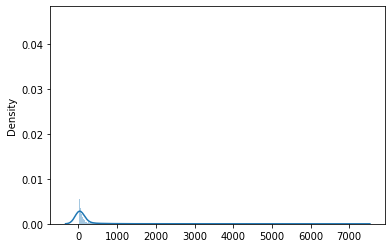

In [59]:
sns.distplot(b, bins = 1000)